# Rollout agent and compute regret scores against solvability

In [37]:
%matplotlib inline

import pickle
import numpy as np
import jax
from typing import Sequence, NamedTuple, Any, Dict
import jax.numpy as jnp 
import wandb 
import tqdm 
import matplotlib.pyplot as plt
import flax.linen as nn
from flax.linen.initializers import constant, orthogonal
import functools
from flax.traverse_util import flatten_dict, unflatten_dict
from functools import partial
import distrax 
from scipy.stats import pearsonr
from numpy.polynomial.polynomial import Polynomial


from jaxmarl.environments.jaxnav.jaxnav_env import JaxNav, listify_reward

from sfl.train.train_utils import load_params
from sfl.train.common.network import ActorCriticRNN, ScannedRNN
from sfl.util.jaxued.jaxued_utils import compute_max_returns, max_mc, positive_value_loss, l1_value_loss, value_disagreement

In [3]:
class Transition(NamedTuple):
    global_done: jnp.ndarray
    last_done: jnp.ndarray
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def compute_score(config, dones, values, max_returns, advantages):
    if config['SCORE_FUNCTION'] == "MaxMC":
        return max_mc(dones, values, max_returns)
    elif config['SCORE_FUNCTION'] == "pvl":
        return positive_value_loss(dones, advantages)
    else:
        raise ValueError(f"Unknown score function: {config['SCORE_FUNCTION']}")

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))


def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

### Constants

In [4]:
N_PARRALEL = 10
ROLLOUT_LEN = 512


### Run ID

In [5]:
# run_name = "alex-plus/multi_robot_ued/v579ftj6"
run_name = "alex-plus/multi_robot_ued/5yvzkn8p"

data_dir = "jax_multirobsim/deploy/data/"
api = wandb.Api()
run = api.run(run_name)
config = run.config
t_config = config["learning"]

print('run name', run_name)

file_name = f'sampled_tc_hard'
# LOAD PARAMS
model_artificat = api.artifact(f"alex-plus/{run.project}/{run.name}-checkpoint:latest")
name = model_artificat.download()
params = load_params(name + "/model.safetensors")
# info_by_agent=True,
env = JaxNav(num_agents=config["env"]["num_agents"], **config["env"]["env_params"])

run name alex-plus/multi_robot_ued/5yvzkn8p


wandb:   1 of 1 files downloaded.  


### Load Test Set

In [6]:
dataset_path = "../data/test_sets/sampled_tc_uniform2500e_1a.pkl"


# load
with open(dataset_path, "rb") as f:
    env_instances = pickle.load(f)

num_agents = env_instances.agent_pos.shape[1]
assert num_agents == env.num_agents, f"num_agents {num_agents} != {env.num_agents}"
num_envs = env_instances.map_data.shape[0]
print('num envs', num_envs)
num_actors = num_agents * num_envs

t_config["NUM_ENVS"] = num_envs * N_PARRALEL
t_config["NUM_ACTORS"] = env.num_agents * t_config["NUM_ENVS"]
t_config["NUM_STEPS"] = ROLLOUT_LEN

num envs 2500


### Rollout

In [7]:

t_config["LOG_DORMANCY"] = True
network = ActorCriticRNN(
    action_dim=env.agent_action_space().shape[0],
    config=t_config,
)

def set_instances(env_instance):
    @partial(jax.vmap, in_axes=(None, 0))
    def _individual_instance(env_instance, n_parrallel: int):
        return env.set_env_instance(env_instance)
    
    return _individual_instance(env_instance, jnp.arange(N_PARRALEL))

rng = jax.random.PRNGKey(0)
rng, rngs = jax.random.split(rng)
# rngs = jax.random.split(rngs, t_config["NUM_ENVS"])
# obs, env_states = jax.vmap(env.set_env_instance, in_axes=(0,))(env_instances)
obs, env_states = jax.vmap(set_instances, in_axes=(0))(env_instances)
print('obs shape', obs["agent_0"].shape)
obs = jax.tree_map(lambda x: x.reshape((t_config["NUM_ENVS"], -1)), obs)
env_states = jax.tree_map(lambda x: x.reshape((t_config["NUM_ENVS"],) + x.shape[2:]), env_states)

zero_carry = ScannedRNN.initialize_carry(t_config["NUM_ACTORS"], t_config["HIDDEN_SIZE"])

runner_state = (
        env_states,
        env_states,
        obs, 
        jnp.zeros(t_config["NUM_ACTORS"], dtype=jnp.bool_),
        zero_carry,
        rng,
    )
        
def _env_step(runner_state, unused):
    env_state, start_state, last_obs, last_done, hstate, rng = runner_state

    # SELECT ACTION
    rng, _rng = jax.random.split(rng)
    obs_batch = batchify(last_obs, env.agents, t_config["NUM_ACTORS"])
    ac_in = (
        obs_batch[np.newaxis, :],
        last_done[np.newaxis, :],
    )
    hstate, pi, value, _ = network.apply(params, hstate, ac_in)
    action = pi.sample(seed=_rng)
    log_prob = pi.log_prob(action)
    env_act = unbatchify(
        action, env.agents, t_config["NUM_ENVS"], env.num_agents
    )
    env_act = {k: v.squeeze() for k, v in env_act.items()}

    # STEP ENV
    rng, _rng = jax.random.split(rng)
    rng_step = jax.random.split(_rng, t_config["NUM_ENVS"])
    obsv, env_state, reward, done, info = jax.vmap(
        env.step, in_axes=(0, 0, 0, 0)
    )(rng_step, env_state, env_act, start_state)
    done_batch = batchify(done, env.agents, t_config["NUM_ACTORS"]).squeeze()
    if env.do_sep_reward:
        reward_batch = listify_reward(reward, do_batchify=True)
    else:
        reward_batch = batchify(reward, env.agents, t_config["NUM_ACTORS"]).squeeze(axis=-1)
    
    ep_done = jnp.tile(done["__all__"], env.num_agents)
    print('num c', info["NumC"].shape)
    info = jax.tree_map(lambda x: x.reshape((t_config["NUM_ACTORS"],)), info)
    transition = Transition(
        ep_done,
        last_done,
        done_batch,
        action.squeeze(),
        value.squeeze(),
        reward_batch,
        log_prob.squeeze(),
        obs_batch,
        info,
    )        
    runner_state = (env_state, start_state, obsv, done_batch, hstate, rng)
    return runner_state, transition

runner_state, traj_batch = jax.lax.scan(
    _env_step, runner_state, None, t_config["NUM_STEPS"]
)
env_state, start_state, last_obs, last_done, hstate, rng = runner_state

last_obs_batch = batchify(last_obs, env.agents, t_config["NUM_ACTORS"])
ac_in = (
    last_obs_batch[np.newaxis, :],
    last_done[np.newaxis, :],
)
_, _, last_val, _ = network.apply(params, hstate, ac_in)
last_val = last_val.squeeze()  

def _calculate_gae(traj_batch, last_val):
    def _get_advantages(gae_and_next_value, transition: Transition):
        gae, next_value = gae_and_next_value
        done, value, reward = (
            transition.global_done, 
            transition.value,
            transition.reward,
        )
        delta = reward + t_config["GAMMA"] * next_value * (1 - done) - value
        gae = (
            delta
            + t_config["GAMMA"] * t_config["GAE_LAMBDA"] * (1 - done) * gae
        )
        return (gae, value), gae

    _, advantages = jax.lax.scan(
        _get_advantages,
        (jnp.zeros_like(last_val), last_val),
        traj_batch,
        reverse=True,
        unroll=16,
    )
    return advantages, advantages + traj_batch.value

advantages, targets = _calculate_gae(traj_batch, last_val)

# SOLVED RATE BY AGENT
@partial(jax.vmap, in_axes=(None, 1, 1, 1))
@partial(jax.jit, static_argnums=(0,))
def _calc_outcomes_by_agent(max_steps: int, dones, returns, info):
    idxs = jnp.arange(max_steps)
    
    @partial(jax.vmap, in_axes=(0, 0))
    def __ep_outcomes(start_idx, end_idx): 
        mask = (idxs > start_idx) & (idxs <= end_idx) & (end_idx != max_steps)
        r = jnp.sum(returns * mask)
        success = jnp.sum(info["GoalR"] * mask)
        collision = jnp.sum((info["MapC"] + info["AgentC"]) * mask)
        timeo = jnp.sum(info["TimeO"] * mask)
        l = end_idx - start_idx
        return r, success, collision, timeo, l
    
    done_idxs = jnp.argwhere(dones, size=10, fill_value=max_steps).squeeze()
    mask_done = jnp.where(done_idxs == max_steps, 0, 1)
    ep_return, success, collision, timeo, length = __ep_outcomes(jnp.concatenate([jnp.array([-1]), done_idxs[:-1]]), done_idxs)        
            
    return {"ep_return": ep_return.mean(where=mask_done),
            "num_episodes": mask_done.sum(),
            "success_rate": success.mean(where=mask_done),
            "collision_rate": collision.mean(where=mask_done),
            "timeout_rate": timeo.mean(where=mask_done),
            "ep_len": length.mean(where=mask_done),
            }
    
print('num c shape', traj_batch.info["NumC"].shape)
        
outcomes = _calc_outcomes_by_agent(t_config["NUM_STEPS"], traj_batch.done, traj_batch.reward, traj_batch.info)
outcomes_by_env = jax.tree_map(lambda x: x.reshape((env.num_agents, t_config["NUM_ENVS"])).swapaxes(0,1), outcomes)




/home/alex/anaconda3/envs/sfl/lib/python3.10/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


obs shape (2500, 10, 205)


/home/alex/anaconda3/envs/sfl/lib/python3.10/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


num c (25000, 1)
num c shape (512, 25000)


-- mean success rate 0.520794


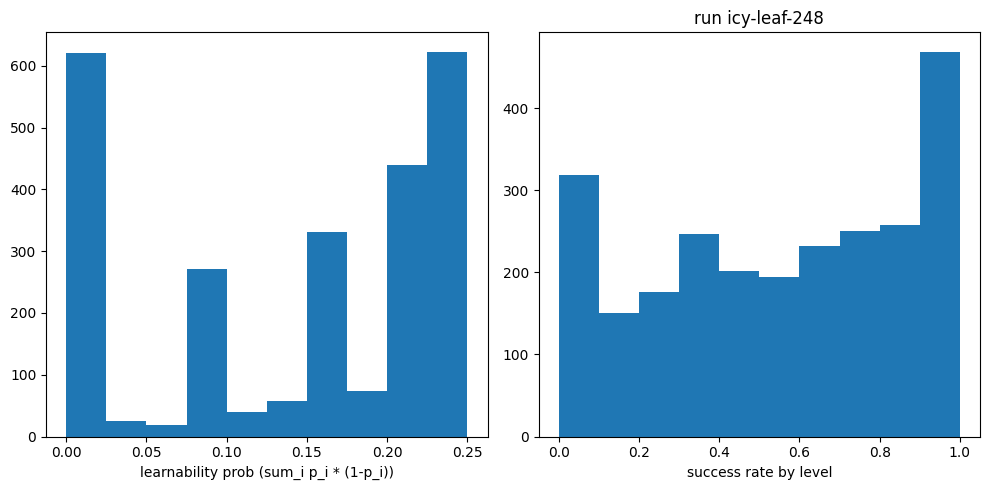

In [8]:
success_by_actor = outcomes["success_rate"]

learn_prob = (success_by_actor * (1 - success_by_actor)).reshape((env.num_agents, t_config["NUM_ENVS"])).sum(axis=0)
mean_success_by_actor = success_by_actor.reshape((env.num_agents, num_envs, N_PARRALEL)).mean(axis=-1)
mean_success_by_level = mean_success_by_actor.mean(axis=0)
learn_prob_by_level = (mean_success_by_actor * (1 - mean_success_by_actor)).sum(axis=0)
# print('learn_prob_by_level', learn_prob_by_level.shape, learn_prob_by_level)
# print('outcomes by env', outcomes_by_env["success_rate"].shape, outcomes_by_env["success_rate"])
# print('num learn prob over 0', jnp.sum(learn_prob > 0))
# print('mean success by level', mean_success_by_level.shape, mean_success_by_level)

reward_by_actor = outcomes["ep_return"]
mean_reward_by_actor = reward_by_actor.reshape((env.num_agents, num_envs, N_PARRALEL)).mean(axis=-1)
mean_reward_by_level = mean_reward_by_actor.mean(axis=0)

print('-- mean success rate', mean_success_by_level.mean())

# PLOT PERFORMANCE
fig, axes = plt.subplots(1, 2, figsize=(10,5))
ax1, ax2 = axes.flatten()
ax1.set_xlabel('learnability prob (sum_i p_i * (1-p_i))')
ax1.hist(learn_prob_by_level, bins=10)
ax2.hist(mean_success_by_level, bins=10)
ax2.set_xlabel('success rate by level')
plt.title(f'run {run.name}')
# ax1.scatter(learn_prob_by_level, max_mc_by_actor, color='blue', alpha=0.25, marker='x')
# ax2.set_xlabel('success rate by level (1/|A| * sum_i p_i)')
# ax2.set_ylabel('MaxMC')
# ax2.scatter(mean_success_by_level, max_mc_by_actor, color='blue', alpha=0.25, marker='x')
# ax3.set_xlabel('learnability prob (sum_i p_i * (1-p_i))')
# ax3.set_ylabel('PVL')
# ax3.scatter(learn_prob_by_level, pvl_by_actor, color='red', alpha=0.25, marker='x')
# ax4.set_xlabel('success rate by level')
# ax4.set_ylabel('PVL')
# ax4.scatter(mean_success_by_level, pvl_by_actor, color='red', alpha=0.25, marker='x')
# ax5.set_xlabel('success rate by level')
# ax5.set_ylabel('Max Return')
# ax5.scatter(mean_success_by_level, max_return_by_actor, color='green', alpha=0.25, marker='x')

fig.tight_layout()

### Calculate regret scores

In [9]:
max_returns_all = compute_max_returns(traj_batch.done, traj_batch.reward)
max_mc_all = max_mc(traj_batch.done, traj_batch.value, max_returns_all)
max_return_by_actor = max_returns_all.reshape((env.num_agents, num_envs, N_PARRALEL)).mean(axis=-1)
max_mc_by_actor = max_mc_all.reshape((env.num_agents, num_envs, N_PARRALEL)).mean(axis=-1)

pvl_by_all = positive_value_loss(traj_batch.done, advantages)
pvl_by_actor = pvl_by_all.reshape((env.num_agents, num_envs, N_PARRALEL)).mean(axis=-1)

l1_value_loss_by_all = l1_value_loss(traj_batch.done, advantages)
l1_value_loss_by_actor = l1_value_loss_by_all.reshape((env.num_agents, num_envs, N_PARRALEL)).mean(axis=-1)

# value_disagreement_by_all = value_disagreement(traj_batch.done, traj_batch.value)
# value_disagreement_by_actor = value_disagreement_by_all.reshape((env.num_agents, num_envs, N_PARRALEL)).mean(axis=-1)
value_disagreement_by_all = traj_batch.value.std(axis=0).reshape((env.num_agents, num_envs, N_PARRALEL)).mean(axis=-1)

print('max_mc_by_actor', max_mc_by_actor.shape)

max_mc_by_actor (1, 2500)


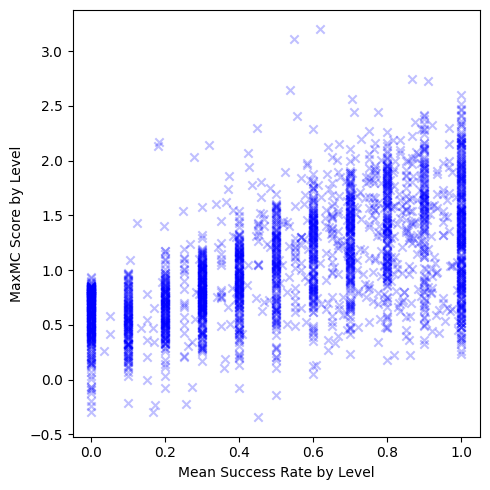

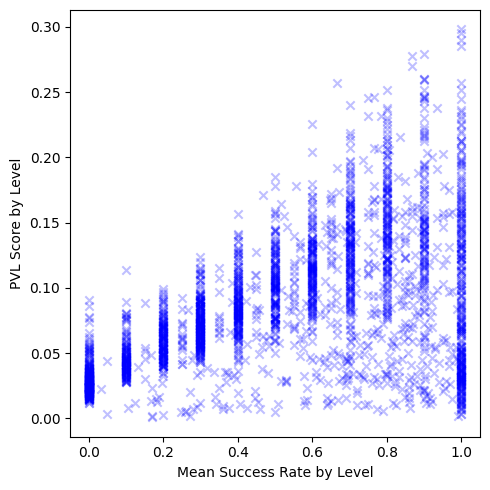

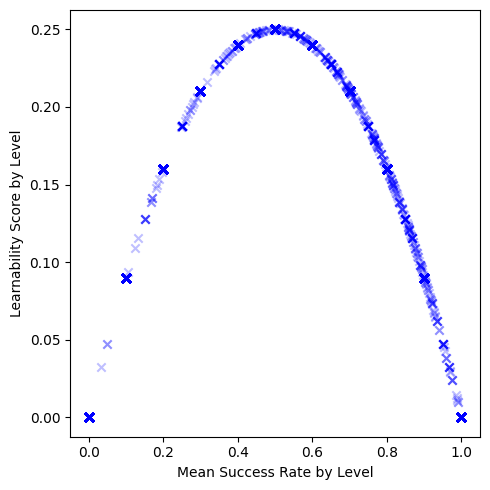

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(mean_success_by_level, max_mc_by_actor, color='blue', alpha=0.25, marker='x')
ax.set_xlabel('Mean Success Rate by Level')
ax.set_ylabel('MaxMC Score by Level')
fig.tight_layout()
# plt.close()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(mean_success_by_level, pvl_by_actor, color='blue', alpha=0.25, marker='x')
ax.set_xlabel('Mean Success Rate by Level')
ax.set_ylabel('PVL Score by Level')
fig.tight_layout()
# plt.close()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(mean_success_by_level, learn_prob_by_level, color='blue', alpha=0.25, marker='x')
ax.set_xlabel('Mean Success Rate by Level')
ax.set_ylabel('Learnability Score by Level')
fig.tight_layout()


Plot regret scores

In [97]:
import matplotlib.pyplot as plt
import numpy as np

GROUP_TO_COLOUR = {
    "Learnability (ours)": '#0173b2', 
    "DR": '#de8f05', 
    "PLR-PVL": '#029e73', 
    "PLR-MaxMC": '#d55e00', 
    "ACCEL-MaxMC": '#cc78bc', 
    "PLR-L1VL": '#ece133', 
    "RobustPLR": '#fbafe4', 
    "RobustACCEL": '#949494', 
    "Perfect Regret (Oracle)": '#56b4e9',
    # '#ece133', 
    # '#56b4e9', 
}

dir_path = "/home/alex/repos/multi-robot-neurips/images/"

def scatter_hist_success(x, y, ax, ax_histx, ax_histy, xbinwidth=0.1, ybinwidth=0.025, l="Learnability", c="#0173b2"):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, c=c, alpha=0.25)
    ax.set_xlabel('Mean Success Rate by Level', fontsize=14)
    ax.set_ylabel(f'{l} Score by Level', fontsize=14)

    xbins = np.arange(0, 1 + xbinwidth, xbinwidth)
    
    ymin, ymax = np.min(y), np.max(y)
    ybins = np.arange(ymin, ymax + ybinwidth, ybinwidth)
    print('ybins', ybins)
    print('y shape', y.shape)
    
    ax_histx.hist(x, bins=xbins, color=c)
    ax_histy.hist(y, bins=ybins, orientation='horizontal', color=c)
    



def scatter_hist_reward(x, y, ax, ax_histx, ax_histy, xbinwidth=0.1, ybinwidth=0.025, l="Learnability", c="#0173b2"):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, c=c, alpha=0.25)
    ax.set_xlabel('Mean Episode Return by Level', fontsize=14)    
    ax.set_ylabel(f'{l} Score by Level', fontsize=14)

    # now determine nice limits by hand:
    xmin, xmax = np.min(x), np.max(x)
    xbins = np.arange(xmin, xmax + xbinwidth, xbinwidth)
    xlim = (int(1/xbinwidth) + 1) * xbinwidth
    print('xlim', xlim)
    xbins = np.arange(xmin, xmax + xbinwidth, xbinwidth)
    
    ymin, ymax = np.min(y), np.max(y)
    ybins = np.arange(ymin, ymax + ybinwidth, ybinwidth)
    
    ax_histx.hist(x, bins=xbins, color=c)
    ax_histy.hist(y, bins=ybins, orientation='horizontal', color=c)
    
def plot_correlation(x, y, ax, min_y=0):
    r, p = pearsonr(x, y)
    print('pearson r', r, p)

    ax.text(0.05, 0.95, f"$r$={r:.2f}, $p$={p:.2}", transform=ax.transAxes, fontsize=14, verticalalignment='top')

    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black')



    # plot quadratic correlation
    p = Polynomial.fit(x, y, 2)
    
    min_x = np.min(x)
    max_x = np.max(x)
    x = np.linspace(min_x, max_x, 1000)
    y = p(x)
    yidx = np.argwhere(y > min_y)
    if yidx.size > 0:
        min_x = x[yidx[0]]
        max_x = x[yidx[-1]]
    print('min_x', min_x, max_x)
    x = np.linspace(min_x, max_x, 1000)
    
    ax.plot(x, p(x), color='black')


ybins [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
y shape (2500,)
xlim 2
min x [-5.52411753] [4.05091911]


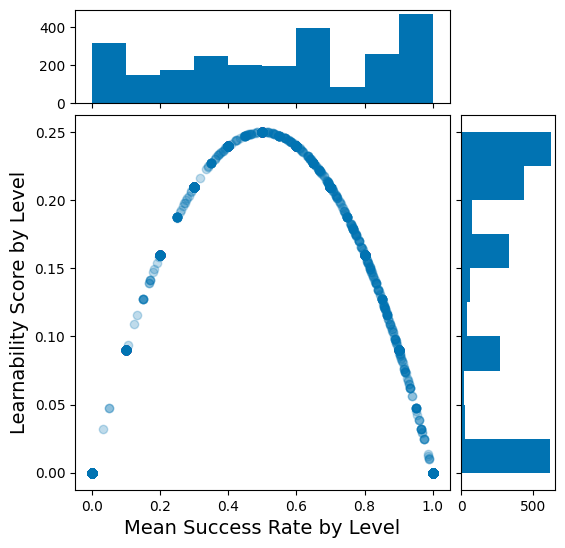

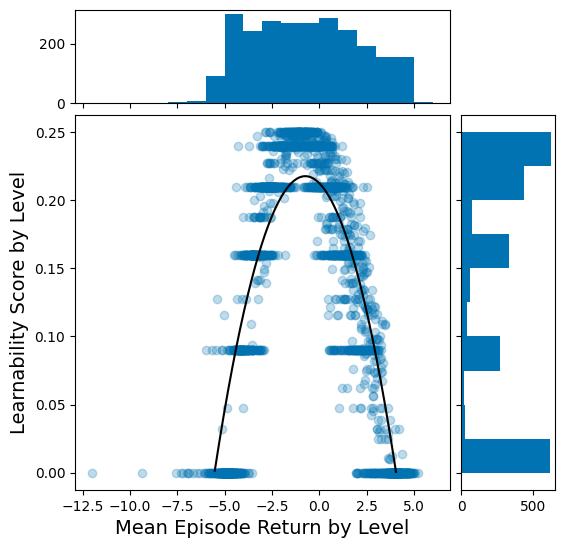

In [98]:
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist_success(mean_success_by_level, learn_prob_by_level, ax, ax_histx, ax_histy)
# save the figure, stop it being cropped

# p = Polynomial.fit(mean_success_by_level, learn_prob_by_level, 2)
# x = np.linspace(0, 1, 100)
# ax.plot(x, p(x), color='black')
plt.savefig(dir_path + 'learnability_hist.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist_reward(mean_reward_by_level, learn_prob_by_level, ax, ax_histx, ax_histy, xbinwidth=1)

p = Polynomial.fit(mean_reward_by_level, learn_prob_by_level, 2)

# select x range based on minimum y value
min_x = np.min(mean_reward_by_level)
max_x = np.max(mean_reward_by_level)
min_y = 0.0
x = np.linspace(min_x, max_x, 1000)
y = p(x)
yidx = np.argwhere(y > min_y)
if yidx.size > 0:
    min_x = x[yidx[0]]
    max_x = x[yidx[-1]]
print('min x', min_x, max_x)
x = np.linspace(min_x, max_x, 1000)
ax.plot(x, p(x), color='black')


# x = np.linspace(-5.2, 4, 100)
# ax.plot(x, p(x), color='black')
plt.savefig(dir_path + 'learnability_hist_rew.pdf', bbox_inches='tight')

ybins [0.00071437 0.02571437 0.05071437 0.07571437 0.10071437 0.12571438
 0.15071438 0.17571438 0.20071438 0.22571438 0.25071438 0.27571438
 0.30071438]
y shape (2500,)
pearson r 0.5095083281152821 2.8835464724990905e-165
min_x [0.] [1.]


xlim 2
pearson r 0.4196485927724882 3.1871786621651747e-107
min_x [-5.90366853] [5.22407675]


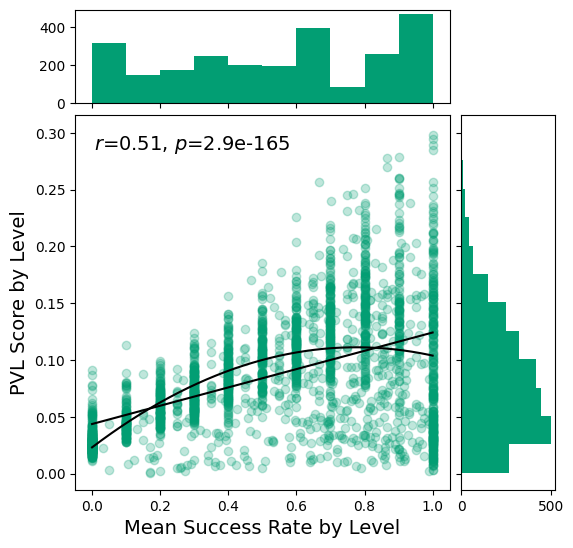

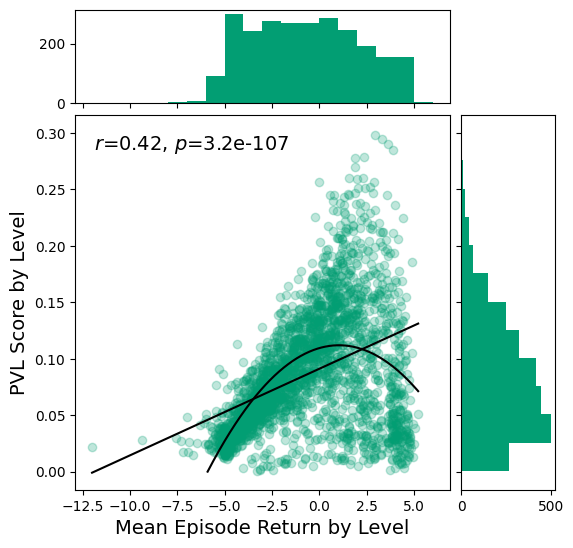

In [99]:
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist_success(mean_success_by_level, pvl_by_actor.squeeze(), ax, ax_histx, ax_histy, l="PVL", c="#029e73")
# save the figure, stop it being cropped

# plot linear correlation
plot_correlation(mean_success_by_level, pvl_by_actor.squeeze(), ax)


plt.savefig(dir_path + 'pvl_hist.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist_reward(mean_reward_by_level, pvl_by_actor.squeeze(), ax, ax_histx, ax_histy, xbinwidth=1, l="PVL", c="#029e73")

plot_correlation(mean_reward_by_level, pvl_by_actor.squeeze(), ax)

# save at dir_path
plt.savefig(dir_path + 'pvl_hist_rew.pdf', bbox_inches='tight')

ybins [-0.3449879  -0.1449879   0.05501211  0.25501211  0.45501211  0.65501212
  0.85501212  1.05501212  1.25501212  1.45501213  1.65501213  1.85501213
  2.05501214  2.25501214  2.45501214  2.65501215  2.85501215  3.05501215
  3.25501215]
y shape (2500,)
pearson r 0.6071107482472435 1.033145454976111e-251
min_x [0.] [1.]


xlim 2
pearson r 0.6054044636805394 6.163271816856919e-250
min_x [-8.12921758] [5.22407675]


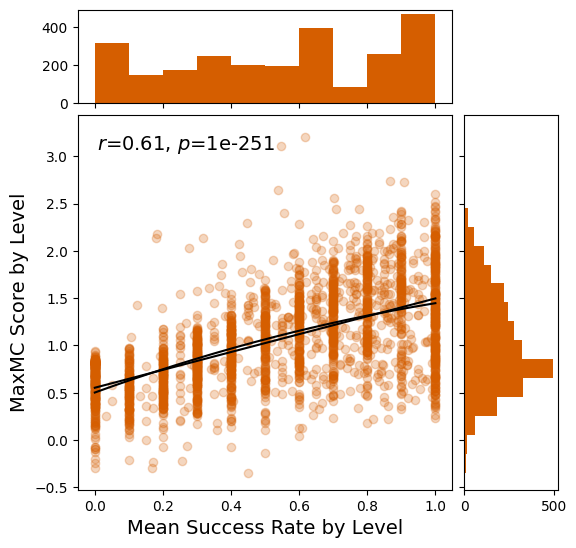

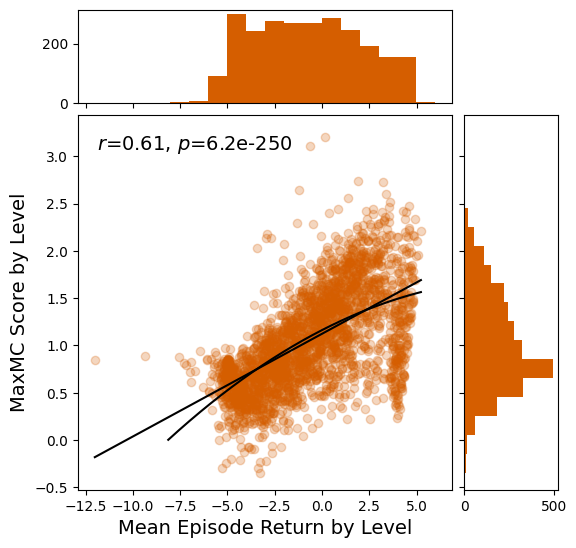

In [100]:
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist_success(mean_success_by_level, max_mc_by_actor.squeeze(), ax, ax_histx, ax_histy, ybinwidth=0.2, l="MaxMC", c="#d55e00")
# save the figure, stop it being cropped

# plot linear correlation
plot_correlation(mean_success_by_level, max_mc_by_actor.squeeze(), ax)


plt.savefig(dir_path + 'max_mc_hist.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist_reward(mean_reward_by_level, max_mc_by_actor.squeeze(), ax, ax_histx, ax_histy, xbinwidth=1, ybinwidth=0.2, l="MaxMC", c="#d55e00")

plot_correlation(mean_reward_by_level, max_mc_by_actor.squeeze(), ax)

plt.savefig(dir_path + 'max_mc_hist_rew.pdf', bbox_inches='tight')

ybins [0.01772886 0.06772886 0.11772886 0.16772886 0.21772886 0.26772887
 0.31772887 0.36772887 0.41772887 0.46772887 0.51772887 0.56772887
 0.61772887 0.66772887 0.71772887 0.76772887 0.81772887 0.86772887
 0.91772887 0.96772888 1.01772888 1.06772888 1.11772888 1.16772888
 1.21772888 1.26772888 1.31772888 1.36772888 1.41772888 1.46772888
 1.51772888 1.56772888 1.61772889 1.66772889 1.71772889 1.76772889
 1.81772889 1.86772889 1.91772889 1.96772889 2.01772889 2.06772889
 2.11772889 2.16772889 2.21772889 2.26772889 2.3177289  2.3677289
 2.4177289  2.4677289  2.5177289  2.5677289  2.6177289  2.6677289
 2.7177289  2.7677289  2.8177289  2.8677289  2.9177289  2.96772891
 3.01772891 3.06772891 3.11772891 3.16772891 3.21772891 3.26772891
 3.31772891 3.36772891 3.41772891 3.46772891 3.51772891 3.56772891
 3.61772892 3.66772892 3.71772892 3.76772892 3.81772892 3.86772892
 3.91772892 3.96772892]
y shape (2500,)
pearson r 0.07443073251911667 0.0001954369648176009
min_x [0.] [1.]


xlim 2
pearson r 0.06860673163130701 0.0005976778738541448
min_x [-6.26596721] [5.22407675]


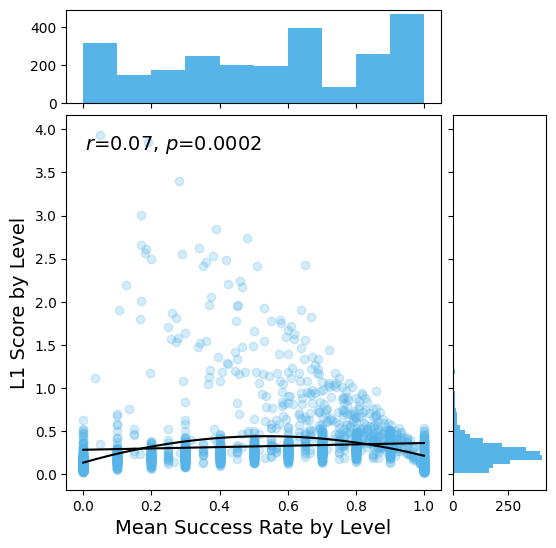

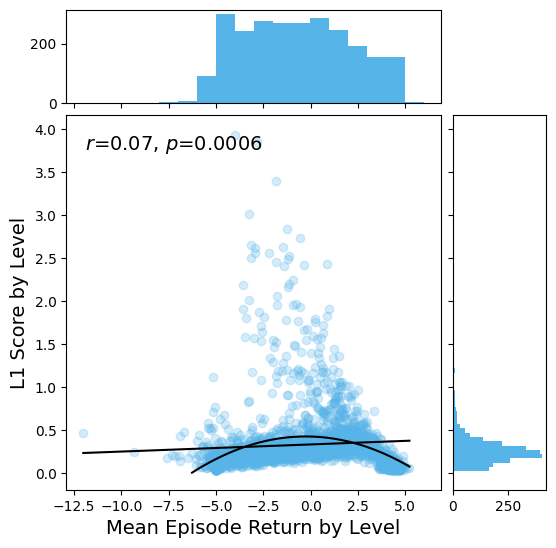

In [101]:
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist_success(mean_success_by_level, l1_value_loss_by_actor.squeeze(), ax, ax_histx, ax_histy, ybinwidth=0.05, l="L1", c="#56b4e9")
# save the figure, stop it being cropped

# plot linear correlation
plot_correlation(mean_success_by_level, l1_value_loss_by_actor.squeeze(), ax)


plt.savefig(dir_path + 'l1_hist.pdf', bbox_inches='tight')


fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist_reward(mean_reward_by_level, l1_value_loss_by_actor.squeeze(), ax, ax_histx, ax_histy, xbinwidth=1, ybinwidth=0.05, l="L1", c="#56b4e9")

plot_correlation(mean_reward_by_level, l1_value_loss_by_actor.squeeze(), ax)

plt.savefig(dir_path + 'l1_hist_rew.pdf', bbox_inches='tight')

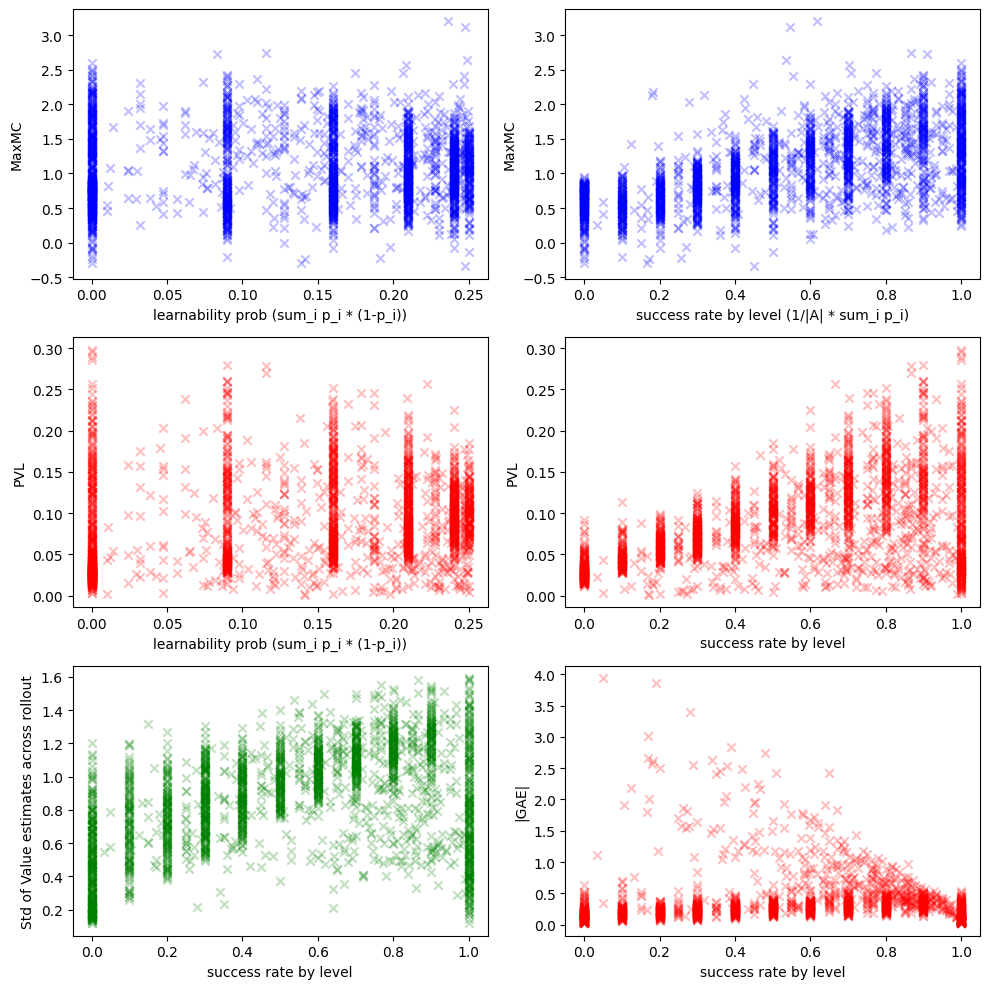

In [102]:

fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
ax1.set_xlabel('learnability prob (sum_i p_i * (1-p_i))')
ax1.set_ylabel('MaxMC')
ax1.scatter(learn_prob_by_level, max_mc_by_actor, color='blue', alpha=0.25, marker='x')
ax2.set_xlabel('success rate by level (1/|A| * sum_i p_i)')
ax2.set_ylabel('MaxMC')
ax2.scatter(mean_success_by_level, max_mc_by_actor, color='blue', alpha=0.25, marker='x')
ax3.set_xlabel('learnability prob (sum_i p_i * (1-p_i))')
ax3.set_ylabel('PVL')
ax3.scatter(learn_prob_by_level, pvl_by_actor, color='red', alpha=0.25, marker='x')
ax4.set_xlabel('success rate by level')
ax4.set_ylabel('PVL')
ax4.scatter(mean_success_by_level, pvl_by_actor, color='red', alpha=0.25, marker='x')
ax5.set_xlabel('success rate by level')
ax5.set_ylabel('Std of Value estimates across rollout')
ax5.scatter(mean_success_by_level, value_disagreement_by_all, color='green', alpha=0.25, marker='x')
ax6.set_xlabel('success rate by level')
ax6.set_ylabel('|GAE|')
ax6.scatter(mean_success_by_level, l1_value_loss_by_actor, color='red', alpha=0.25, marker='x')

fig.tight_layout()

## Histograms